# Runoff 
Runoff refers to the lateral movement of water across catchments to river channels, and includes both surface and subsurface components. In this notebook we will apply some of the analysis techniques we saw in class.  

As usual, we will start by loading the libraries we need and importing a timeseries dataset for one of the catchments in the CAMELS-GB dataset. 

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
from sklearn.linear_model import TheilSenRegressor

SHARED_DATADIR = Path(os.environ["SHARED_DATA_DIR"])
DATADIR = SHARED_DATADIR / '8344e4f3-d2ea-44f5-8afa-86d2987543a9' / 'data'

# Load the data
id = '97002'
data = pd.read_csv(os.path.join(DATADIR, 'timeseries', f'CAMELS_GB_hydromet_timeseries_{id}_19701001-20150930.csv'), parse_dates=[0])
data.head()


,date,precipitation,pet,temperature,discharge_spec,discharge_vol,peti,humidity,shortwave_rad,longwave_rad,windspeed
0,1970-10-01,9.93,1.02,8.91,NaN,NaN,1.31,6.01,61.76,325.33,7.65
1,1970-10-02,4.01,1.41,7.66,NaN,NaN,1.76,5.11,93.56,294.20,10.03
2,1970-10-03,7.27,1.17,8.77,NaN,NaN,1.40,5.41,61.95,321.14,5.41
3,1970-10-04,3.77,0.06,9.74,NaN,NaN,0.23,7.76,42.83,341.28,7.27
4,1970-10-05,1.19,1.56,9.46,NaN,NaN,1.86,5.49,92.13,299.08,7.90


Let's make a hydrograph with this data:

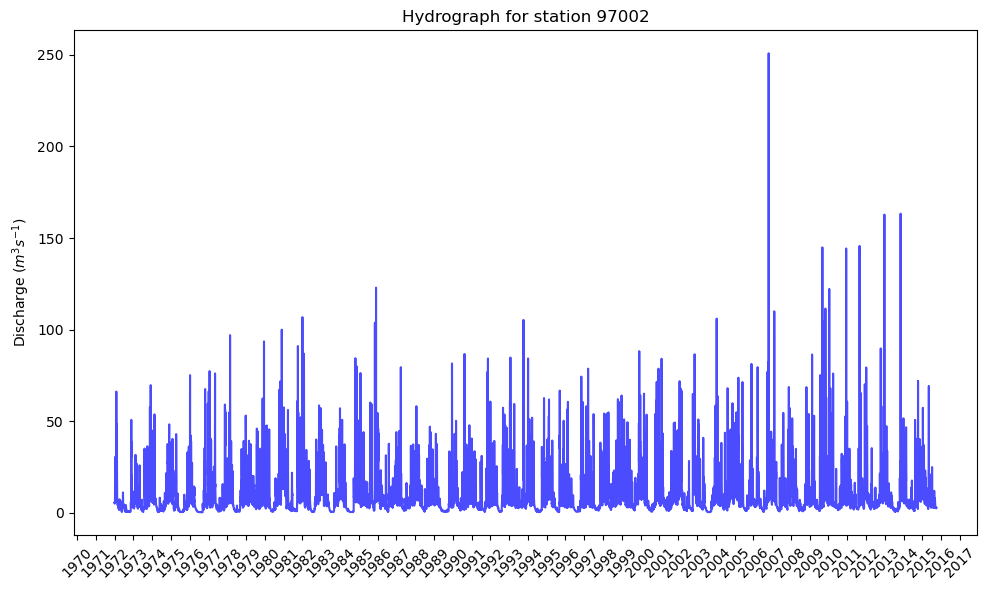

In [2]:
plt.figure(figsize=(10, 6))
plt.plot(data['date'], data['discharge_vol'], color='b', alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.ylabel('Discharge $(m^{3}s^{-1})$')
plt.title(f'Hydrograph for station {id}')
plt.tight_layout()
plt.show()

This shows us the daily streamflow hydrograph for the full data record. We might want to look at data for a particular (water) year. Look back through `water-balance.ipynb` to remind yourself how to add the water year as an additional column. Now select data for a particular year and plot the hydrograph.

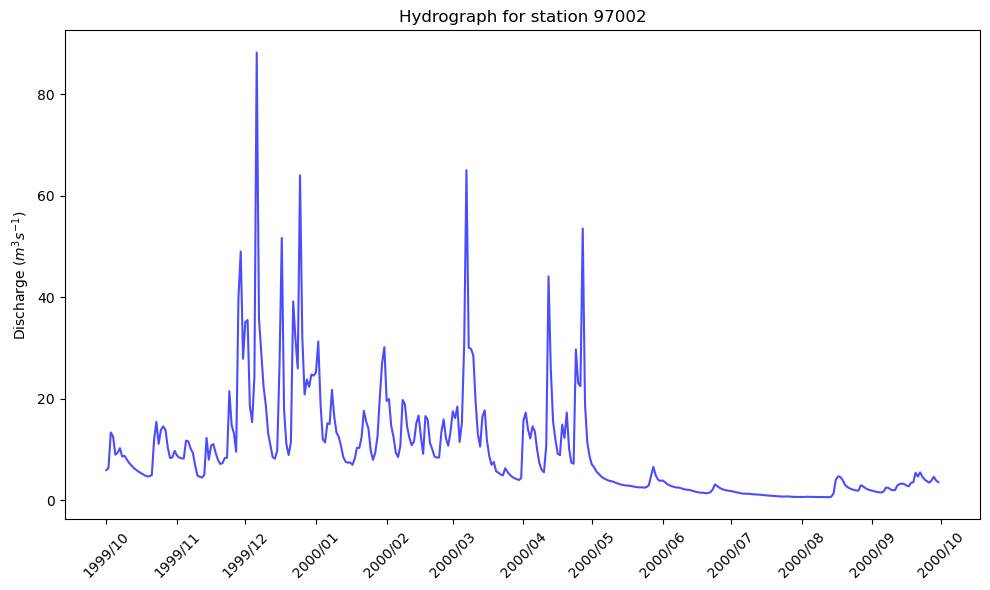

In [3]:
data['water_year'] = data['date'].dt.to_period('Y-SEP')
data_2006 = data[data['water_year'] == '2000']

plt.figure(figsize=(10, 6))
plt.plot(data_2006['date'], data_2006['discharge_vol'], color='b', alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))
plt.xticks(rotation=45)
plt.ylabel('Discharge $(m^{3}s^{-1})$')
plt.title(f'Hydrograph for station {id}')
plt.tight_layout()
plt.show()

As we discussed in class, hydrographs can either be continuous or event-based. Can you pick out an individual storm event from this hydrograph and try plotting it? 

Now let's think about how flow varies on average over the course of a year. It would be nice to have an understanding of the mean as well as the variance. We can do this using boxplots. 

        date  precipitation   pet  temperature  discharge_spec  discharge_vol  \
0 1970-10-01           9.93  1.02         8.91             NaN            NaN   
1 1970-10-02           4.01  1.41         7.66             NaN            NaN   
2 1970-10-03           7.27  1.17         8.77             NaN            NaN   
3 1970-10-04           3.77  0.06         9.74             NaN            NaN   
4 1970-10-05           1.19  1.56         9.46             NaN            NaN   

   peti  humidity  shortwave_rad  longwave_rad  windspeed water_year  month  
0  1.31      6.01          61.76        325.33       7.65       1971     10  
1  1.76      5.11          93.56        294.20      10.03       1971     10  
2  1.40      5.41          61.95        321.14       5.41       1971     10  
3  0.23      7.76          42.83        341.28       7.27       1971     10  
4  1.86      5.49          92.13        299.08       7.90       1971     10  


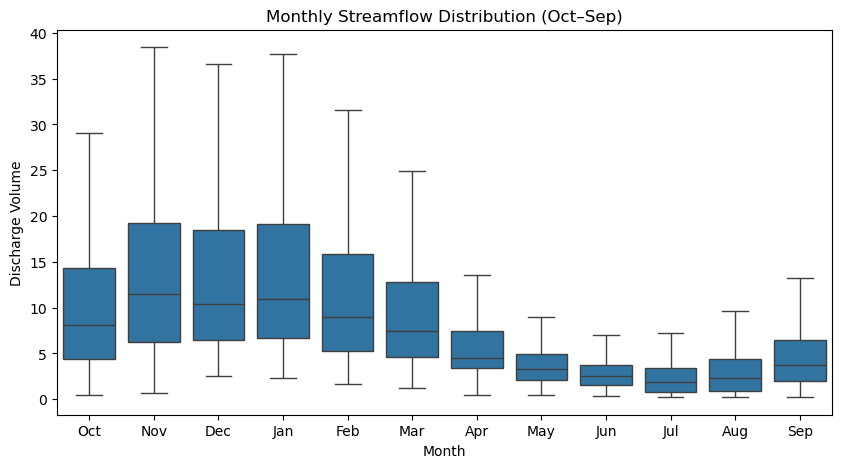

In [4]:
import seaborn as sns 

data['month'] = data['date'].dt.month 
print(data.head())

# Define the order of months for October (10) to September (9) (i.e. the start of the water year to the end)
month_order = [10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]
month_labels = ["Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep"]

# Create the boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x="month", y="discharge_vol", order=month_order, showfliers=False)
plt.xticks(ticks=range(12), labels=month_labels)
plt.xlabel("Month")
plt.ylabel("Discharge Volume")
plt.title("Monthly Streamflow Distribution (Oct–Sep)")
plt.show()

We can see that the flow is more variable (i.e. the interquartile range of the boxplots is greater) in the winter. We can also see that the high flows are significantly higher in the winter compared to the summer. Note that we have excluded outliers (`showfliers=False`). What would happen if we didn't do this? 

So far we have considered how flow varies in time. It's also helpful to disregard time altogether and just look at the individual daily flow values. The first thing we might want to do is check how the data is distributed. We can use kernel density estimation (KDE) to estimate the probability density function. 

0.22 250.9


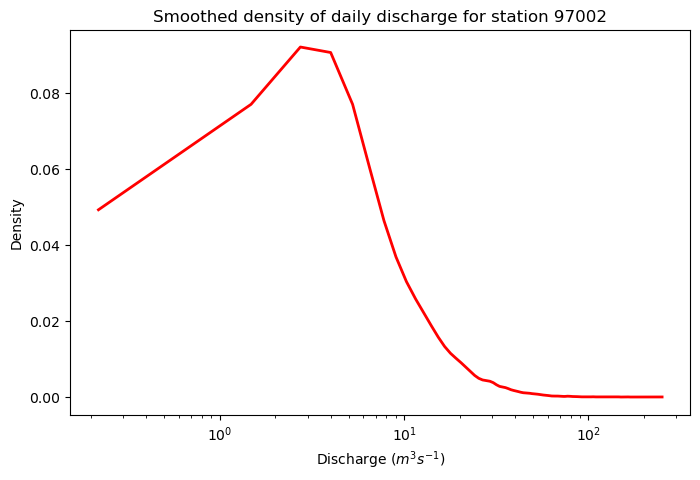

In [5]:
from scipy.stats import gaussian_kde

# Apply KDE to estimate PDF
data = data.dropna()
discharge_vol = data['discharge_vol']
kde = gaussian_kde(data['discharge_vol'])
x_vals = np.linspace(discharge_vol.min(), discharge_vol.max(), 200)
print(x_vals[0], x_vals[-1])
y_vals = kde(x_vals)

# Plot KDE
plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, color="red", lw=2)
plt.xlabel('Discharge $(m^{3}s^{-1})$')
plt.ylabel('Density')
plt.title(f'Smoothed density of daily discharge for station {id}')
plt.xscale('log')

plt.show()


What is this telling us? The PDF describes the relative likelihood of a random variable (streamflow, in our case) taking on a particular value. The area under the curve equals one (i.e. according the PDF we have fitted, streamflow must take on a value between the start and end of the curve). We can see that the most likely streamflow value is around 3 $m^3 s^{-1}$. Now let's plot the cumulative density function:

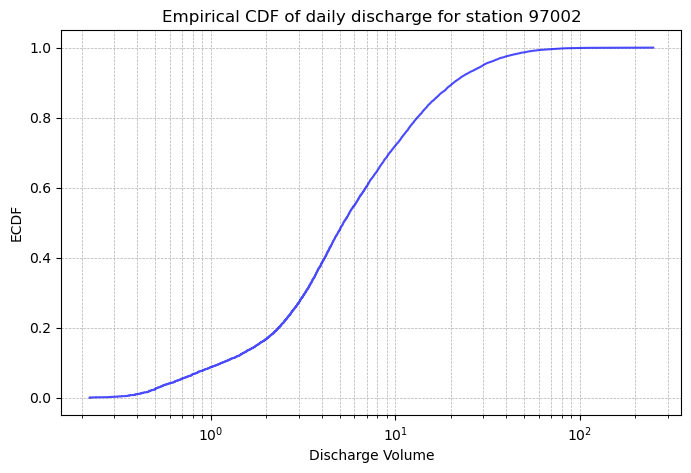

In [6]:
# Sort discharge data for ECDF
x = np.sort(data["discharge_vol"])
y = np.arange(1, len(x) + 1) / len(x)  # Compute probabilities

# Plot ECDF
plt.figure(figsize=(8, 5))
plt.plot(x, y, color="blue", alpha=0.7)

# Set log scale for x-axis
plt.xscale("log")

# Formatting
plt.xlabel("Discharge Volume")
plt.ylabel("ECDF")
plt.title(f'Empirical CDF of daily discharge for station {id}')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

Now let's plot the flow duration curve. To do this we need to calculate the exceedance probabilities (i.e. the probabilities that a flow is equalled or exceeded). The equation for the exceedance probability is given by the Weibull formula, expressed

$
P=100*\left(\frac{M}{n+1}\right)
$ 

where $M$ is the ranked position of individual daily flow values and $n$ is the total number of data observations in the data record. 

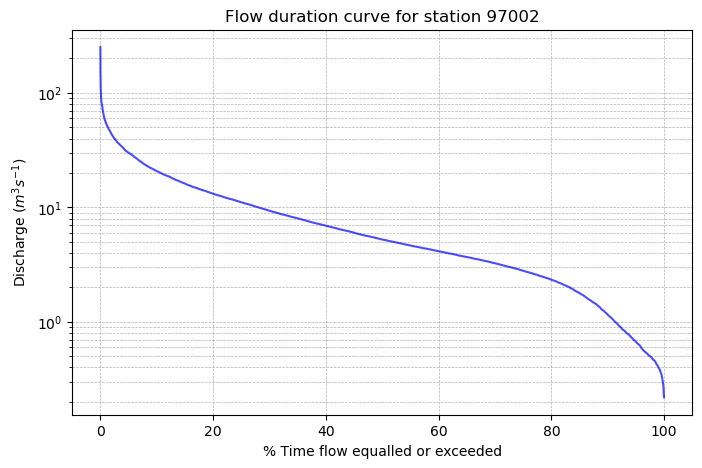

In [7]:
# Handle duplicated values by taking the average value of the group
data['rank'] = data['discharge_vol'].rank(method='average', ascending=False)
data = data.sort_values(['rank'])
data['P'] = 100. * (data['rank'] / (data.shape[0] + 1))

# Plot FDC
plt.figure(figsize=(8, 5))
plt.plot(data['P'], data['discharge_vol'], color="blue", alpha=0.7)
plt.xlabel('% Time flow equalled or exceeded')
plt.ylabel('Discharge $(m^{3}s^{-1}$)')
plt.title(f'Flow duration curve for station {id}')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.yscale("log")
plt.show()


## Further work 
We're going to have a look at changes in the Colorado River downstream of the Hoover Dam, which started operating in 1936. This dataset is obviously not part of the CAMELS-GB dataset - instead, I have uploaded it to the Github repository, so the csv file should be present in the `notebooks` directory. Let's start by plotting the hydrograph:


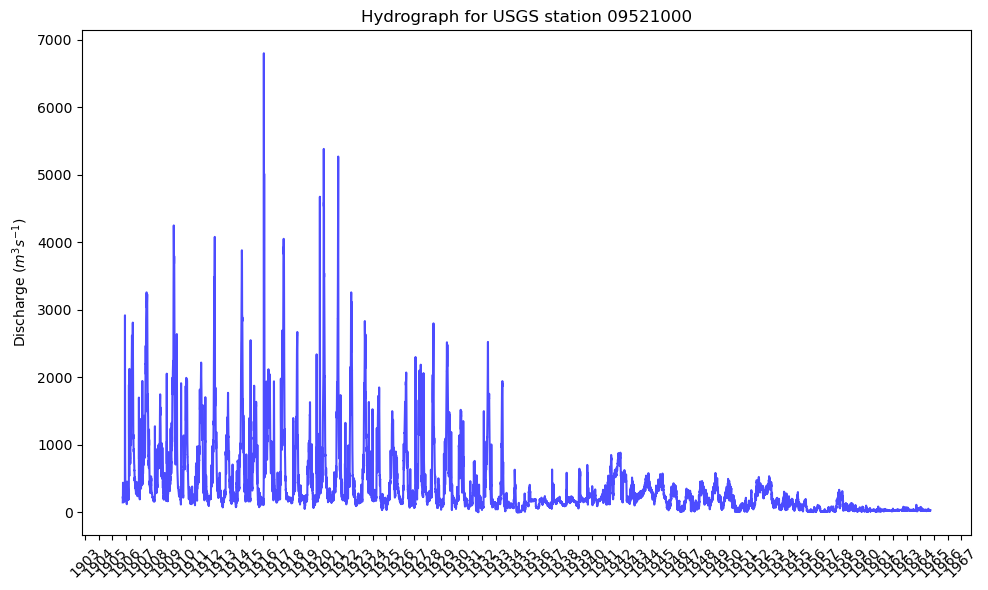

In [ ]:
data = pd.read_csv("notebooks/USGS_09521000.csv", parse_dates=['Date'])
data['year'] = data['Date'].dt.year 
data = data[(data['Date'] < pd.to_datetime('1965-10-01')) & (data['Date'] > pd.to_datetime('1905-10-01'))]
data['Flow'] *= 0.0283168 # cubic feet per second -> m3/s

# Let's plot the hydrograph 
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Flow'], color='b', alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.ylabel('Discharge $(m^{3}s^{-1})$')
plt.title(f'Hydrograph for USGS station 09521000')
plt.tight_layout()
plt.show()


Find out the purpose of the Hoover Dam - why was it built in the first place? Given this knowledge, can you explain the change in hydrological regime that you can see?

Now plot the flow duration curve for the Colorado River *before* and *after* the dam was built. 

In [10]:
data_pre = data[data['Date'].dt.year < 1933].copy()
data_post = data[data['Date'].dt.year >= 1933].copy()

# Create a function to compute the FDC probabilities, to avoid repetition
def fdc(data):
    data['rank'] = data['Flow'].rank(method='average', ascending=False)
    data = data.sort_values(['rank'])
    data['P'] = 100. * (data['rank'] / (data.shape[0] + 1))
    return data[['P', 'Flow']]

fdc_pre = fdc(data_pre)
fdc_post = fdc(data_post)

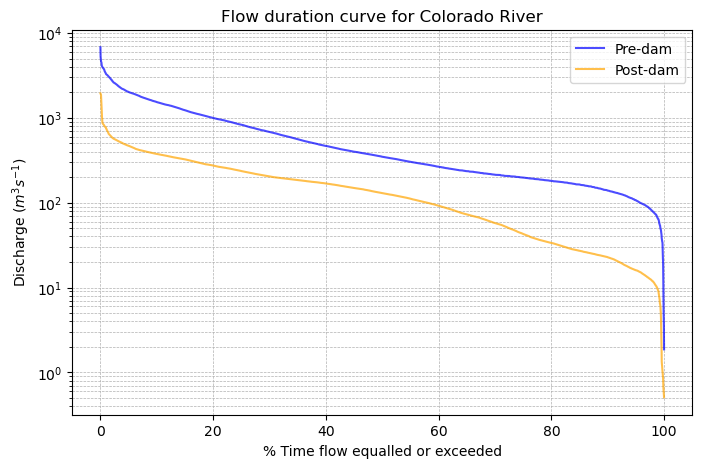

In [11]:
# Plot FDC
plt.figure(figsize=(8, 5))
plt.plot(fdc_pre['P'], fdc_pre['Flow'], color="blue", alpha=0.7, label='Pre-dam')
plt.plot(fdc_post['P'], fdc_post['Flow'], color="orange", alpha=0.7, label='Post-dam')
plt.xlabel('% Time flow equalled or exceeded')
plt.ylabel('Discharge $(m^{3}s^{-1}$)')
plt.title(f'Flow duration curve for Colorado River')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.yscale("log")
plt.show()